<a href="https://colab.research.google.com/github/Dheerajmishrajnv/MLdawn/blob/master/success_of_Covid2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dheerajmishra123","key":"d317c27f92ef9749172efab333bd0b40"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                               title                                             size  lastUpdated          downloadCount  
----------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
gpreda/covid19-tweets                                             COVID19 Tweets                                    21MB  2020-08-14 07:51:12           2013  
christianlillelund/passenger-list-for-the-estonia-ferry-disaster  The Estonia Disaster Passenger List               14KB  2020-07-26 15:40:17            567  
futurecorporation/epitope-prediction                              COVID-19/SARS B-cell Epitope Prediction            1MB  2020-07-24 02:53:28            477  
Cornell-University/arxiv                                          arXiv Dataset                                    877MB  2020-08-14 23:50:57           1345  
claytonmiller/ashrae-global-thermal-comfort-da

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 1.14G/1.15G [00:39<00:00, 31.0MB/s]
100% 1.15G/1.15G [00:39<00:00, 31.1MB/s]


In [ ]:
!ls

covid19-radiography-database.zip  kaggle.json  sample_data


In [ ]:
!unzip covid19-radiography-database.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
 
from tensorflow import keras
from tensorflow.keras import layers,preprocessing
from tensorflow.keras.models import Sequential

In [ ]:
base_dir = '/content/COVID-19 Radiography Database'    

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
)

Found 2905 files belonging to 3 classes.
Using 2324 files for training.


In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32)


Found 2905 files belonging to 3 classes.
Using 581 files for validation.


In [ ]:
class_names = train_data.class_names
print(class_names)


['COVID-19', 'NORMAL', 'Viral Pneumonia']


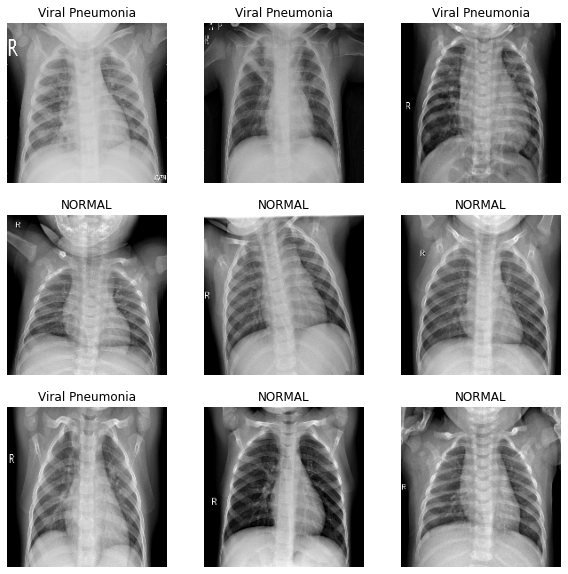

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(180, 
                                                              180,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


In [ ]:
num_classes = 3

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=5
)


Epoch 1/5
73/73 [==============================] - 91s 1s/step - loss: 0.8401 - accuracy: 0.5886 - val_loss: 0.5877 - val_accuracy: 0.7229
Epoch 2/5
73/73 [==============================] - 81s 1s/step - loss: 0.5291 - accuracy: 0.7694 - val_loss: 0.4335 - val_accuracy: 0.8210
Epoch 3/5
73/73 [==============================] - 81s 1s/step - loss: 0.4483 - accuracy: 0.8167 - val_loss: 0.3779 - val_accuracy: 0.8675
Epoch 4/5
73/73 [==============================] - 80s 1s/step - loss: 0.3777 - accuracy: 0.8515 - val_loss: 0.3111 - val_accuracy: 0.8864
Epoch 5/5
73/73 [==============================] - 80s 1s/step - loss: 0.3332 - accuracy: 0.8782 - val_loss: 0.3569 - val_accuracy: 0.8589


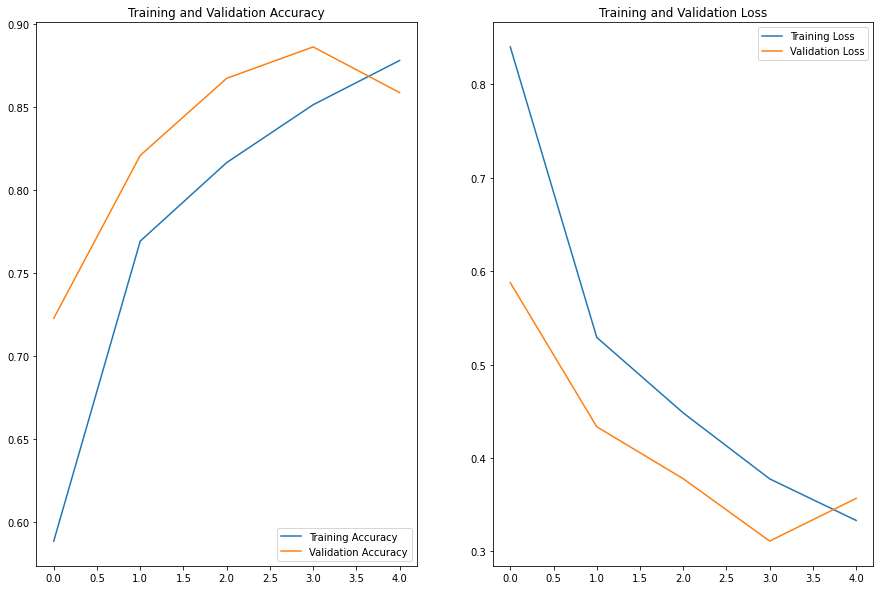

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
test_dir='/content/COVID-19 Radiography Database/COVID-19/COVID-19 (1).png'
img = keras.preprocessing.image.load_img(
    test_dir, target_size=(180,180)
)


In [ ]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to COVID-19 with a 83.84 percent confidence.


In [ ]:
test_dir='/content/COVID-19 Radiography Database/NORMAL/NORMAL (1).png'
img = keras.preprocessing.image.load_img(
    test_dir, target_size=(180,180)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to NORMAL with a 94.79 percent confidence.
